# Introduction to Machine Learning

<img src="https://github.com/jeremiedecock/polytechnique-cse204-2018/blob/master/logo.jpg?raw=1" style="float: left; width: 15%" />

[CSE204-2018](https://moodle.polytechnique.fr/course/view.php?id=6784) Lab session #02

Jérémie DECOCK

<a href="https://colab.research.google.com/github/jeremiedecock/polytechnique-cse204-2018/blob/master/lab_session_02.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/jeremiedecock/polytechnique-cse204-2018/master?filepath=lab_session_02.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open and Execute in Binder"></a>

## Objectives

- Implement the *k-Nearest Neighbors* algorithm
- Use it to solve classification and regression problems
- Define the decision boundaries
- Explain the weaknesses of this algorithm

## Imports and tool functions

In [1]:
%matplotlib inline

import numpy as np
#comment
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import sklearn.neighbors
from sklearn.utils import shuffle

from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
def gen_2d_classification_samples(n_samples = 20):

    cov = np.diag([2., 2.])

    x1 = np.random.multivariate_normal(mean=[0., 0.], cov=cov, size=n_samples)
    y1 = np.full(n_samples, 1, dtype=np.int)

    x2 = np.random.multivariate_normal(mean=[4., 0.], cov=cov, size=n_samples)
    y2 = np.full(n_samples, 2, dtype=np.int)

    x3 = np.random.multivariate_normal(mean=[2., 4.], cov=cov, size=n_samples)
    y3 = np.full(n_samples, 3, dtype=np.int)

    X = np.concatenate([x1, x2, x3])
    y = np.concatenate([y1, y2, y3])

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

In [3]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_2d_classification_samples(dataframe, model=None, voronoi=False):
    plt.figure(figsize=(8, 8))
    
    df = dataframe  # make an alias
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x1', 'x2', 'y']"
    assert df.columns.values.tolist() == ['x1', 'x2', 'y'], ERROR_MSG1
    
    ERROR_MSG2 = "The `dataframe` parameter should be a Pandas DataFrame having the following labels (in column 'y'): [1, 2, 3]"
    labels = pd.unique(df.y).tolist()
    labels.sort()
    assert labels == [1, 2, 3], ERROR_MSG2
    
    if model is not None:
        if voronoi:
            # Compute the Voronoi cells
            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)
            fig.set_size_inches(8, 8)
        
        # Compute the model's decision boundaries
        
        h = .02  # step size in the mesh

        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries

        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)

## Nearest Neighbor algorithm

Today you will implement one of the simplest (but quite powerful) machine learning algorithm: the *Nearest Neighbor* algorithm and its extension the *k-Nearest Neighbors* algorithm (or *kNN*).
Both can be used for classification and regression tasks.

Considering a dataset $\mathcal{D}=\{(\mathcal{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples, the *Nearest Neighbor* model assigns an input vector $\boldsymbol{x}$ to the label $y_{\arg\min_{i=1,\dots, n}d(x, x_i)}$ of its closest neighbor in $\mathcal{D}$.

The distance function $d$ is used to define what is the closest neighbor. This can be any metric measure but the *Minkowski distance* (especially the classical Euclidian distance $d_2$) is the most common choice. It is defined as follow:

$$d_q: \mathbb{R}^p \times \mathbb{R}^p \to \mathbb{R}$$

$$\boldsymbol{u}, \boldsymbol{v} \mapsto ||\boldsymbol{u} - \boldsymbol{v}||_q = \left( \sum_{j=1}^p |u_j - v_j|^q \right)^{1/q}$$

When $q=2$, $d_q$ is the *Euclidian distance*

$$d_2(\boldsymbol{u}, \boldsymbol{v}) = \sqrt{\sum_{j=1}^{p} (u_j - v_j)^2}$$

When $q=1$, $d_q$ is the *Manhattan distance*

$$d_1(\boldsymbol{u}, \boldsymbol{v}) = \sum_{j=1}^{p} |u_j - v_j|$$

When $q=\infty$, $d_q$ is the  *Tchebychev distance*

$$d_{\infty}(\boldsymbol{u}, \boldsymbol{v}) = \max_{j=1,\dots,p} |u_j - v_j|$$

### Exercise 1

We consider the following dataset (where 'x1' and 'x2' are examples features and where 'y' is the examples label):

In [4]:
data = [[0, 0, 1],
        [0, 1, 1],
        [1, 1, 2],
        [1, 0, 3]]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,0,0,1
1,0,1,1
2,1,1,2
3,1,0,3


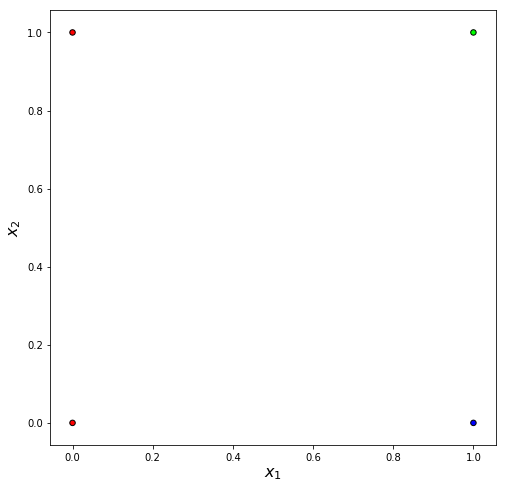

In [5]:
plot_2d_classification_samples(df)

What label will be predicted by the Nearest Neighbor algorithm for the point $x = \pmatrix{0 \\ 0.5}$ ?

### Answer:
For the point $x = \pmatrix{0 \\ 0.5}$, the label predicted will be "1".

If you have $n$ examples in $p$ dimensions in the dataset, what it the training error of the Nearest Neighbor algorithm (in classification) ? Why ?

### Answer:
TODO

### Exercise 2

Consider this new dataset (where 'volume (mL)' and 'caffeine (g)' are the examples features and where 'drink' is the label):

In [6]:
data = [[250, 0.025, 'tea'],
        [100, 0.01,  'tea'],
        [125, 0.05,  'coffe'],
        [250, 0.1,   'coffe']]

df = pd.DataFrame(data, columns=['volume (mL)', 'caffeine (g)', 'drink'])
df

,volume (mL),caffeine (g),drink
0,250,0.025,tea
1,100,0.010,tea
2,125,0.050,coffe
3,250,0.100,coffe


Use the Nearest Neighbor method to predict the label of a 125mL drink having 0.015g of caffeine.

### Answer:
So we check, using euclidean distance, the closest point would be 125 mL and 0.050g, which means that the label predicted would be cofee.

What is wrong with this prediction ? How to solve this problem ?

### Answer:
What's wrong is that both features do not have the same weight, in the sense that volume's unit is to large compared to caffeine one. A way to solve the problem would be to do a 1D classification of the ratio of caffeine/volume.

## Nearest Neighbor method with Scikit Learn

Let's play with the Scikit Learn implementation of the Nearest Neighbor algorithm.
The official documentation is there: https://scikit-learn.org/stable/modules/neighbors.html

### Classification

We begin with a "toy" **classification problem**.

Use the `gen_2d_classification_samples()` function (defined above) to generate a dataset.

In [10]:
df = gen_2d_classification_samples(n_samples=20)
df.head()

,x1,x2,y
0,0.243416,4.085141,3
1,0.229693,1.597271,1
2,5.294301,8.017340,3
3,-0.053882,-0.356709,1
4,4.463221,1.951480,2


Here, examples are defined in $\mathbb{R}^2$ (features are stored in columns 'x1' and 'x2').
Example's labels are defined in the 'y' column.

The 'y' column contains three possible labels: "1", "2" and "3" respectively represented by the red, green and blue colors in the following figure.

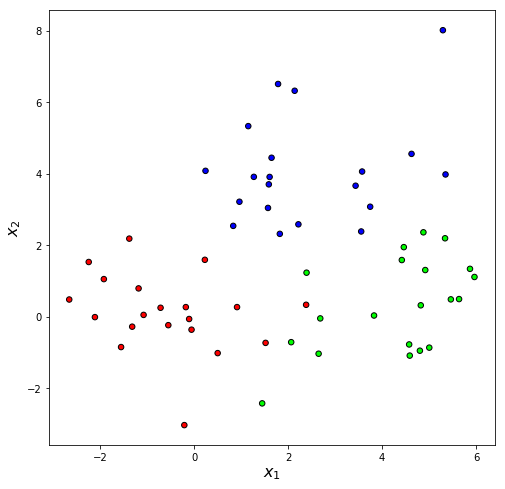

In [11]:
plot_2d_classification_samples(df)

Thus this toy problem is a multiclass classification problem.

Once the dataset is ready, let's make the classifier and train it with the following code:

In [12]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)

In [13]:
model.fit(X=df[['x1', 'x2']], y=df['y'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Exercise 3

Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2 \\ 2}, x_{p2} = \pmatrix{2 \\ 6}, x_{p3} = \pmatrix{6 \\ 0}$$

In [19]:
print("The class x1 belong to is: " + str(model.predict([[-2,2]])))
print("The class x2 belong to is: " + str(model.predict([[2,6]])))
print("The class x3 belong to is: " + str(model.predict([[6,0]])))

The class x1 belong to is: [1]
The class x2 belong to is: [3]
The class x3 belong to is: [2]


Is the training step (`model.fit()` function) longer to execute than the prediction step (`model.predict()` function) ? Why ?

### Answer:
The training step would take longer time to execute since it needs to compute the nearest neighbors for every point in the dataset, while predict is doing it for only one point.

The next cell show the decision boundary of the model. Explain what is a decision boundary in classification.

### Answer:
The decision boundary would be the boundaries of the set of points belonging to each class.

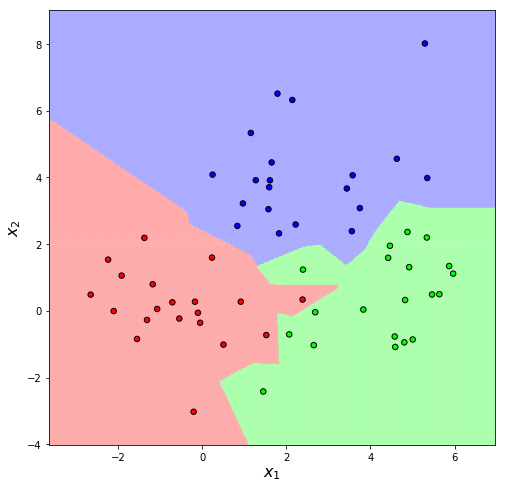

In [20]:
plot_2d_classification_samples(df, model=model)

The next cell generates the *Voronoï diagram* of the dataset.
What does this figure illustrates about the Nearest Neighbor method?

The Voronoï diagram makes a partition of the feature space $\mathcal{X}$.
Each partition is a *cell*. What do cells represent?

### Answer:
    1. This shows us that the nearest neighbor method coincides with the Voronoi cell boundaries.
    2. Each cells contain a specific point A belonging to data, and theses cells are the set of point closest (for a given metric) to the point A.

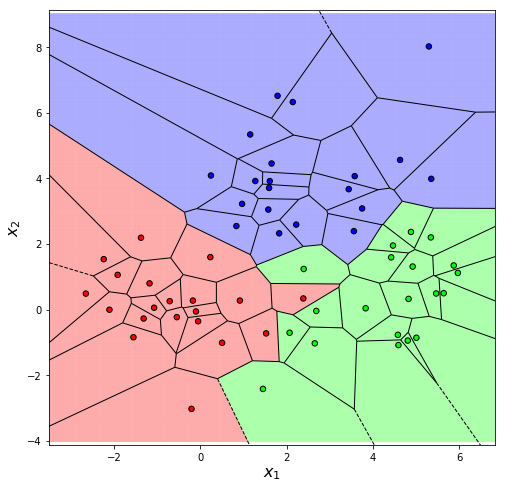

In [23]:
plot_2d_classification_samples(df, model=model, voronoi=True);

### Regression

After the "toy" classification problem, let's work on a toy **regression problem**.

The next cell generates a dataset (where 'x' is the feature and 'y' the label to predict).

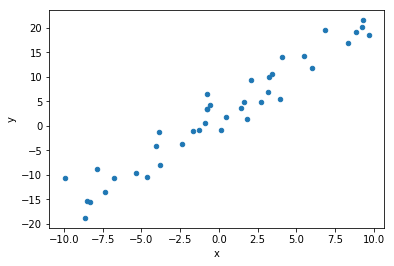

In [24]:
N_SAMPLES = 40
x = np.random.uniform(low=-10., high=10., size=N_SAMPLES)
y = 2. * x + 3. + np.random.normal(scale=3., size=x.shape)

df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
#df.plot(x='x', y='y', style='o-')
df.plot.scatter(x='x', y='y');

Once the dataset is ready, let's make the regressor and train it with the following code:

In [25]:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)

In [26]:
model.fit(df[['x']], df['y'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

### Exercise 4

Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2}, x_{p2} = \pmatrix{2}, x_{p3} = \pmatrix{6}$$

In [30]:
print("The class x1 belong to is: " + str(model.predict([[-2]])))
print("The class x2 belong to is: " + str(model.predict([[2]])))
print("The class x3 belong to is: " + str(model.predict([[6]])))

The class x1 belong to is: [-1.00526212]
The class x2 belong to is: [9.38959763]
The class x3 belong to is: [11.84182466]


### Plot the model's decision function

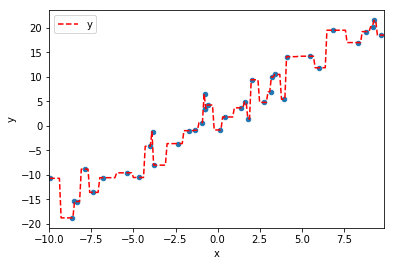

In [31]:
x_pred = np.arange(-10, 10, 0.1).reshape(-1, 1)
y_pred = model.predict(x_pred)

df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

ax = df.plot.scatter(x='x', y='y')
df_pred.plot(x='x', y='y', style='r--', ax=ax);

### Exercise 5

Do you think this model has good performances in *generalization* ? Why ?

### Answer:
I would not think that this model has good performance, since the model is made to fit every data possible, and might very well omit other points to predict in the future. Phenomena of overfitting.

## k-Nearest Neighbors algorithm

The *Nearest Neighbor* method is very sensitive to noise: if an example in $\mathcal{D}$ is wrongly labeled or positioned, all points in its Voronoï cell will be wrong too. The *k Neareast Neighbor* fix this weakness by considering for each prediction the label of several neighbors instead of just one.

Considering a dataset $\mathcal{D}=\{(\mathcal{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples and a meta parameter $k \in \mathbb{N}*$, the *$k$ Nearest Neighbors* model assigns an input vector $\boldsymbol{x}$ to the label $y_{\arg\min_{i=1,\dots, n}d(x, x_i)}$ of its $k$ closest neighbor in $\mathcal{D}$.
Let's write $\mathcal{N}_k(\boldsymbol{x})$ the set of the $k$ nearest neighbors of $\boldsymbol{x}$ in $\mathcal{D}$.

- For classification problems, the label assigned to $\boldsymbol{x}$ is the **most represented label** among the nearest neighbors (vote)
$$f(\boldsymbol{x}) = \arg\max_c \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} \delta(y_i, c)$$

- For regression problems, the label assigned to $\boldsymbol{x}$ is computed based on the **mean** of the labels of its nearest neighbors $\mathcal{N}_k(\boldsymbol{x})$
$$f(\boldsymbol{x}) = \frac{1}{k} \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} y_i$$

### Exercise 6

We consider the following dataset (where 'x1' and 'x2' are the examples features and where 'y' is the examples label):

In [32]:
data = [[1, 2, '+'],
        [2, 1, '+'],
        [2, 2, '-'],
        [2, 3, '+'],
        [3, 1, '-'],
        [3, 2, '+']]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,1,2,+
1,2,1,+
2,2,2,-
3,2,3,+
4,3,1,-
5,3,2,+


- Draw this dataset on a sheet of paper.
- Draw the decision boundary of a Nearest Neighbor model (i.e. 1NN).
- Draw the decision boundary of a 3 Nearest Neighbor model (i.e. 3NN)
- How many errors these two classifiers make on the training dataset ?
- What label these two classifiers predict for the point $x = \pmatrix{4 \\ 0.5}$ ?

### Answer:
From the two classifiers:
    - 1NN makes 0 errors on the training dataset
    - 3NN makes 4 errors on the training data set
Label are written below on the code part.

For (4,0.5), 1NN predicts: [2]


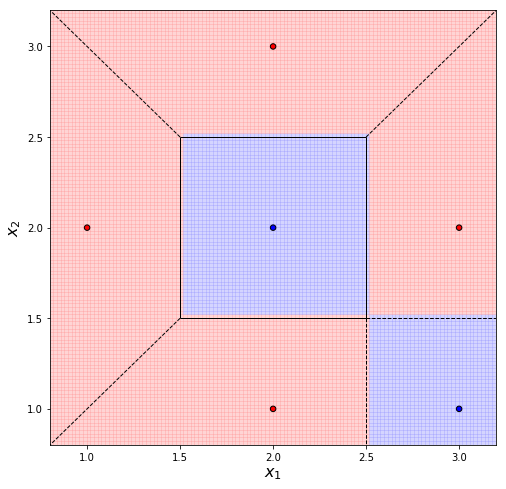

In [43]:
data = [[1, 2, 1],
        [2, 1, 1],
        [2, 2, 2],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1]]
#define + := 1 and - := 2
df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
model.fit(X=df[['x1', 'x2']], y=df['y'])
print("For (4,0.5), 1NN predicts: "+str(model.predict([[4,0.5]])))

def plot_2d_classification_samples1(dataframe, model=None, voronoi=False):
    plt.figure(figsize=(8, 8))
    
    df = dataframe  # make an alias
    
    if model is not None:
        if voronoi:
            # Compute the Voronoi cells
            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)
            fig.set_size_inches(8, 8)
        
        # Compute the model's decision boundaries
        
        h = .02  # step size in the mesh

        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries

        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)
    
plot_2d_classification_samples1(df, model = model,voronoi = True)


For (4,0.5), 3NN predicts: [1]


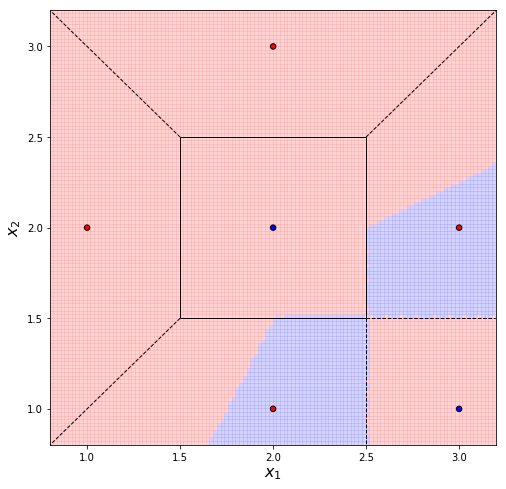

In [44]:
data = [[1, 2, 1],
        [2, 1, 1],
        [2, 2, 2],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1]]
#define + := 1 and - := 2
df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model.fit(X=df[['x1', 'x2']], y=df['y'])
print("For (4,0.5), 3NN predicts: "+str(model.predict([[4,0.5]])))

def plot_2d_classification_samples1(dataframe, model=None, voronoi=False):
    plt.figure(figsize=(8, 8))
    
    df = dataframe  # make an alias
    
    if model is not None:
        if voronoi:
            # Compute the Voronoi cells
            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)
            fig.set_size_inches(8, 8)
        
        # Compute the model's decision boundaries
        
        h = .02  # step size in the mesh

        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries

        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)
    
plot_2d_classification_samples1(df, model = model,voronoi = True)



## k-Nearest Neighbor (kNN) with Scikit Learn

### Classification

First we make the dataset.

In [46]:
df = gen_2d_classification_samples()

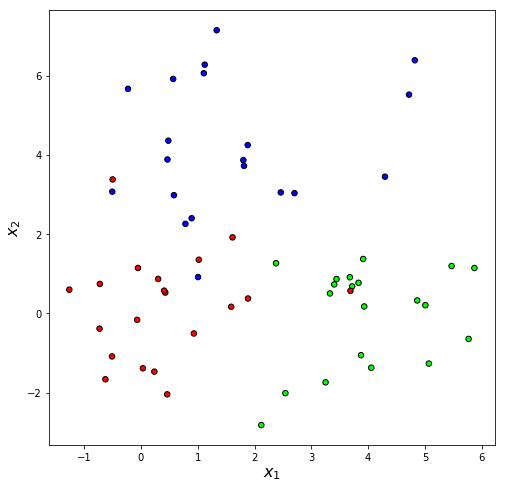

In [47]:
plot_2d_classification_samples(df)

Then we make the classifier, train it and plot the decision boundaries:

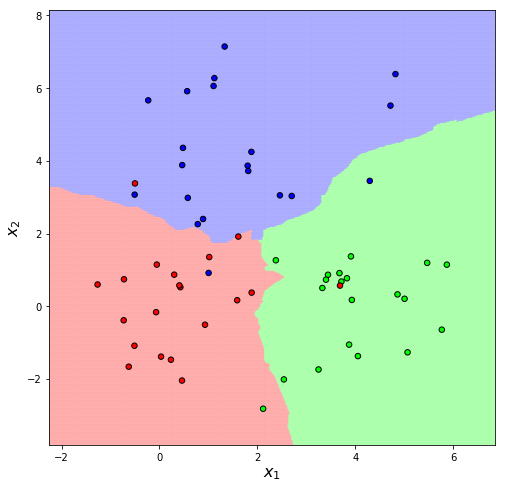

In [58]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)

model.fit(df[['x1', 'x2']], df['y'])

plot_2d_classification_samples(df, model=model)

### Exercise 7

The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

Change the value of this parameter and observe what happen.
What is the influence of the number of neighbors on the boundaries ?

### Answer:
After changing this parameter multiple times, we observe that the numbers of correct fitting for training dataset is higher, and observe as well that there are small zones for a class that is including in another one, that might shows how specific a high number of neighbors turns the classification in.

When you face a very noised dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

### Answer:
When faced to very noised dataset, we should increase k in order to have classes that are more reliable and has at least points that are correctly placed.

Is the Voronoi diagram useful for the kNN case (i.e. when $k>1$) ?

### Answer:
When $k>1$, Voronoi diagram is not useful anymore, since it is showing the points closest to a fixed one, whereas kNN would be classifying using groups of points. Voronoi diagram is not showing how the classifying process is working.

Plot the decision boundary with $k=2$ and describe what happen in case of equal vote?

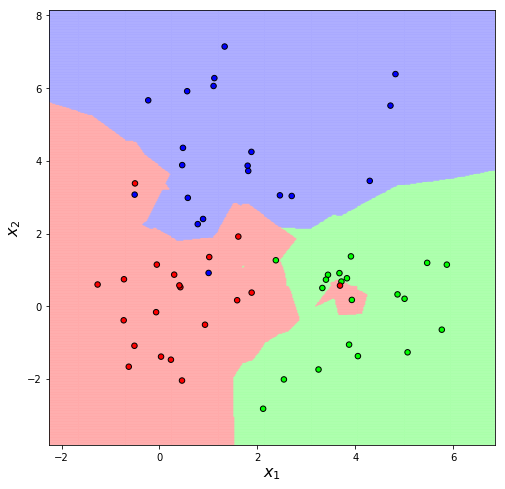

In [59]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2)

model.fit(df[['x1', 'x2']], df['y'])

plot_2d_classification_samples(df, model=model)

### Answer:
We see that the choice in case of equal voting would be to choose according to the following priority red > green > blue.

Add the `weights = "distance"` parameter in `KNeighborsClassifier`'s constructor. What changes can you observe on the decision boundary? Explain how labels are computed with this new parameter.

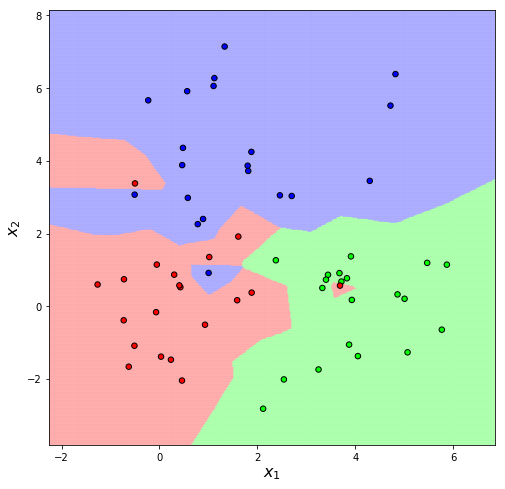

In [60]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=2, weights="distance")

model.fit(df[['x1', 'x2']], df['y'])

plot_2d_classification_samples(df, model=model)

### Answer:
Now the change that we see is that the classes are defined such that, when there is an equality, then we choose the minimum distance label.

### Regression

First we make the dataset.

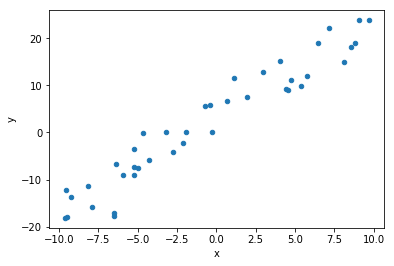

In [61]:
N_SAMPLES = 40
x = np.random.uniform(low=-10., high=10., size=N_SAMPLES)
y = 2. * x + 3. + np.random.normal(scale=3., size=x.shape)

df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
#df.plot(x='x', y='y', style='o-')
df.plot.scatter(x='x', y='y');

Then we make the classifier, train it and plot the decision boundaries:

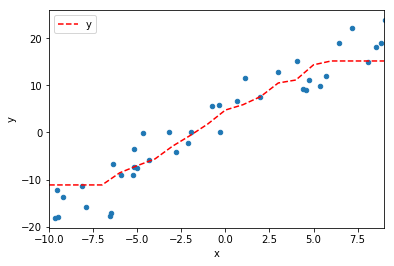

In [74]:
n_neighbors = 15

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors)

model.fit(df[['x']], df['y'])

x_pred = np.arange(-10, 10, 1).reshape(-1, 1)
y_pred = model.predict(x_pred)

df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

ax = df.plot.scatter(x='x', y='y')
df_pred.plot(x='x', y='y', style='r--', ax=ax);

The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

Change the value of this parameter and observe what happen.
What is the influence of the number of neighbors on the decision function ?

### Answer:
Apparently, the influence of the number of neighbors on the decision function is to have trend curve model. We also notice it is going through less points of the training data set. We are making the curve smoother, averaging the points' ordinate.

When you face a very noised dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$ ?

### Answer:
Similarly to the previous answer, we should increase $k$, in order to have a prediction that dominates the noise and determines properly.

## Bonus

### Exercise 8

Solve the Titanic problem with the k Nearest Neighbors method. Reuse the code of the first lab session.

### Exercise 9

Write your own implementation for the k Nearest Neighbor algorithm.
Write a `knn()` function that takes two arguments:
- *data*: the observed dataset (examples with their labels)
- *xpred*: a list of examples to predict

This function should return the sequence of predicted labels.